In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors
from matplotlib import gridspec

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 56,Total memory: 100.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59782,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 56
Started: Just now,Total memory: 100.00 GiB
Comm: tcp://127.0.0.1:48752,Total threads: 7
Dashboard: http://127.0.0.1:41726/status,Memory: 12.50 GiB
Nanny: tcp://127.0.0.1:59723,


In [3]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_Eulerian = (E_Eulerian.rename({'E_SSUV':'E_Eulerian'}))
E_Eulerian

/dev/shm/pbs.55570.datarmor0/ipykernel_37650/1246658237.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))


<xarray.Dataset>
Dimensions:         (frequency_band: 14, lon_bins: 359, lat_bins: 119)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>

In [4]:
# Lagrangian
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50_XCYC'

p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

/home1/datahome/zcaspar/mit_equinox/mitequinox/parcels.py:1361: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  data = xr.open_zarr(data_path, **kwargs)


<xarray.DataArray 'E_Lagrangian' (frequency_band: 14, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-f22fc506b3af0623a50a535b5340f75fE, shape=(14, 359, 119), dtype=float64, chunksize=(1, 359, 60), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

In [5]:
# 2D binned Depth
V = ["SSUV"]
T = ["T60"]

sub = 1
dl = 2.
lon = np.arange(-180.,180., dl)
lat = np.arange(-60., 60., dl)
    
for v in V:
    for t in T:
        
        # read data
        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        #ds = ds.where(ds.Depth>500, drop=False)
        #ds = ds.load()
        
        # lat, lon binning
        ds['lon'] = 0*ds.face+ds.XC
        ds['lat'] = 0*ds.face+ds.YC
        N = histogram(
                      ds.lon.load(), ds.lat.load(), 
                      bins=[lon, lat], 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )

        E = histogram(
                      ds.lon.load(), ds.lat.load(),
                      bins=[lon, lat], 
                      weights= ds.Depth.load(), 
                      dim=['i', 'j', 'face'], 
                      block_size=None
                     )
        
        # get binned results
        Depth_bin = (E/N).rename('E_depth').rename({'lon_bin': 'lon_bins','lat_bin': 'lat_bins'})        

/dev/shm/pbs.55570.datarmor0/ipykernel_37650/3424089979.py:14: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))


In [ ]:
ds

In [6]:
# Together
ds_E = xr.merge([E_Eulerian,E_lagrangian,Depth_bin])
ds_E

<xarray.Dataset>
Dimensions:         (lon_bins: 538, lat_bins: 178, frequency_band: 14)
Coordinates:
  * lon_bins        (lon_bins) float64 -179.5 -179.0 -178.5 ... 177.5 178.5
  * lat_bins        (lat_bins) float64 -59.5 -59.0 -58.5 ... 57.0 57.5 58.5
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 68, 45), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 538, 90), meta=np.ndarray>
    E_depth         (lon_bins, lat_bins) float64 nan nan nan nan ... nan nan nan

In [15]:
ds_E.frequency_band

<xarray.DataArray 'frequency_band' (frequency_band: 14)>
array(['total', 'low', 'diurnal_0dot1', 'diurnal_0dot2', 'diurnal_0dot3',
       'diurnal_0dot4', 'semidiurnal_0dot1', 'semidiurnal_0dot2',
       'semidiurnal_0dot3', 'semidiurnal_0dot4', 'inertial_0dot1',
       'inertial_0dot2', 'inertial_0dot3', 'inertial_0dot4'], dtype=object)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'

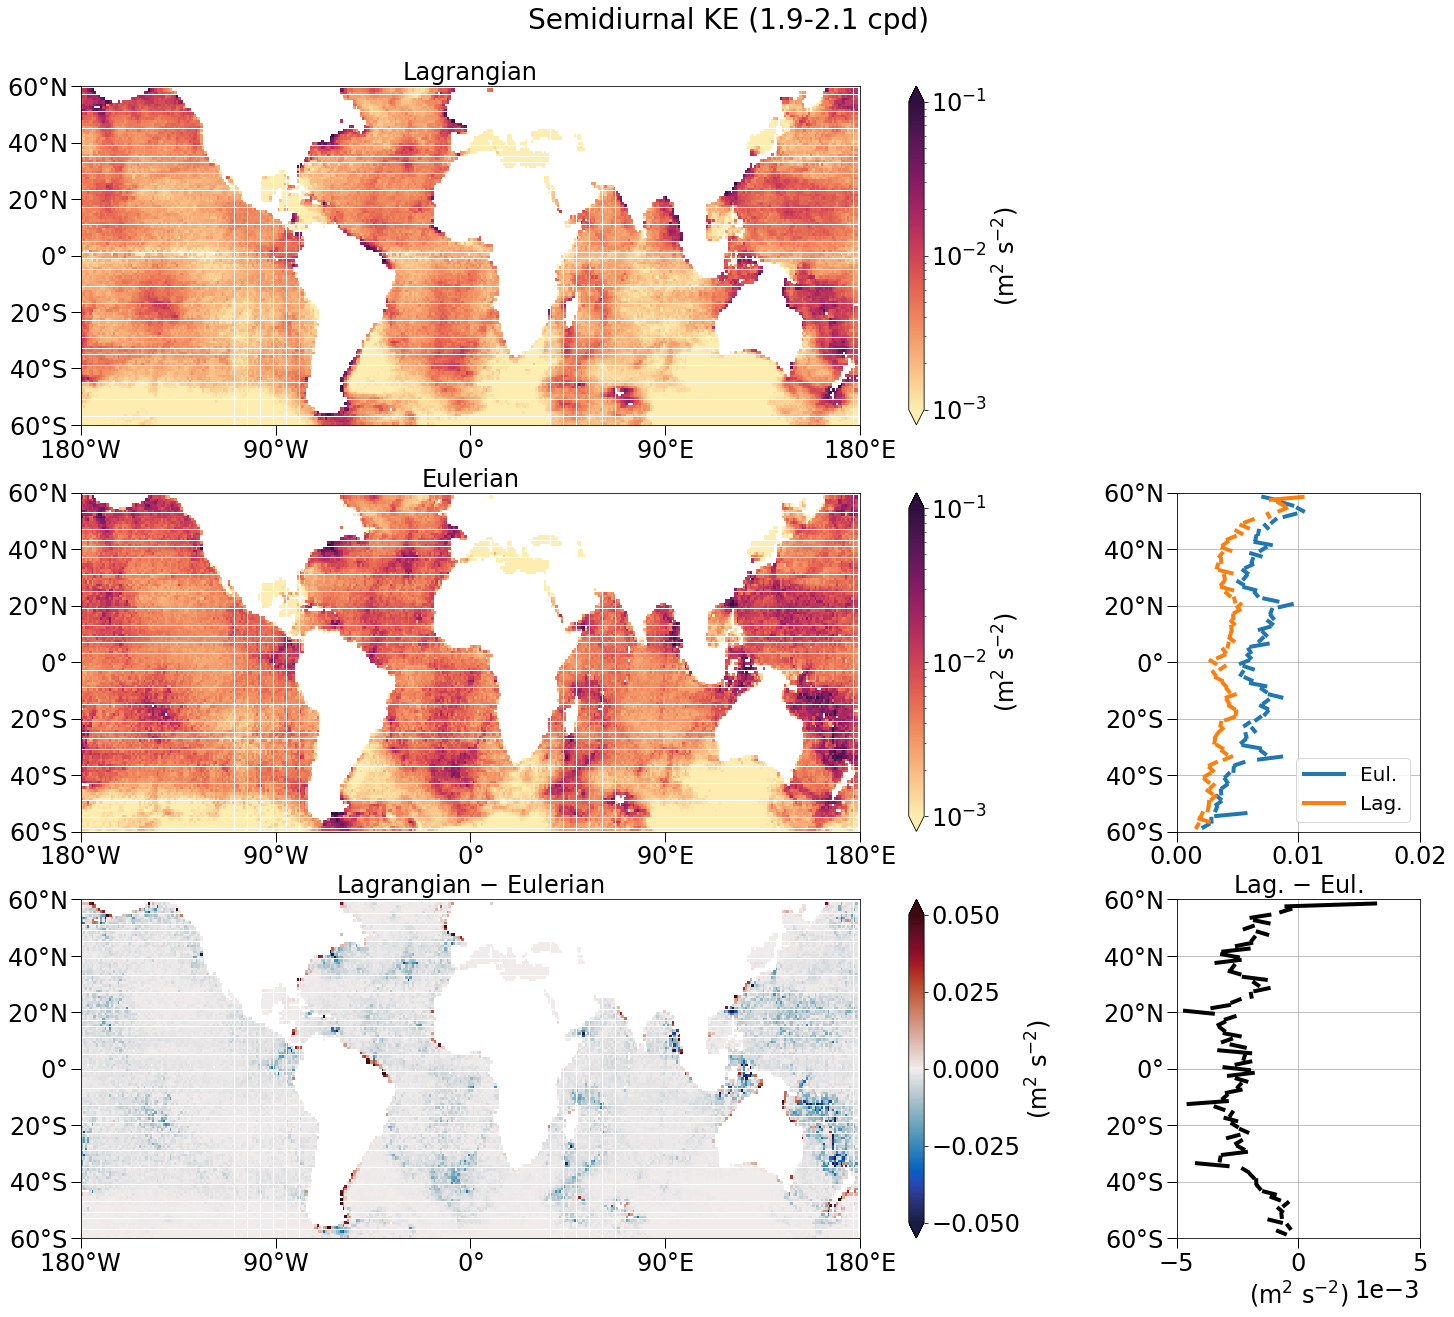

In [16]:
# semidiurnal 
upper_limit = 0.1
plt.rc('font', size=24) 

font_size = 24
band = 'semidiurnal_0dot1' # bandwidth 1.9-2.1 cpd
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)

fig.suptitle("Semidiurnal KE (1.9-2.1 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_yticks([-0.005, -0.0025, 0, 0.0025, 0.005])
ax.set_yticklabels(['-0.005','','0','','0.005'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

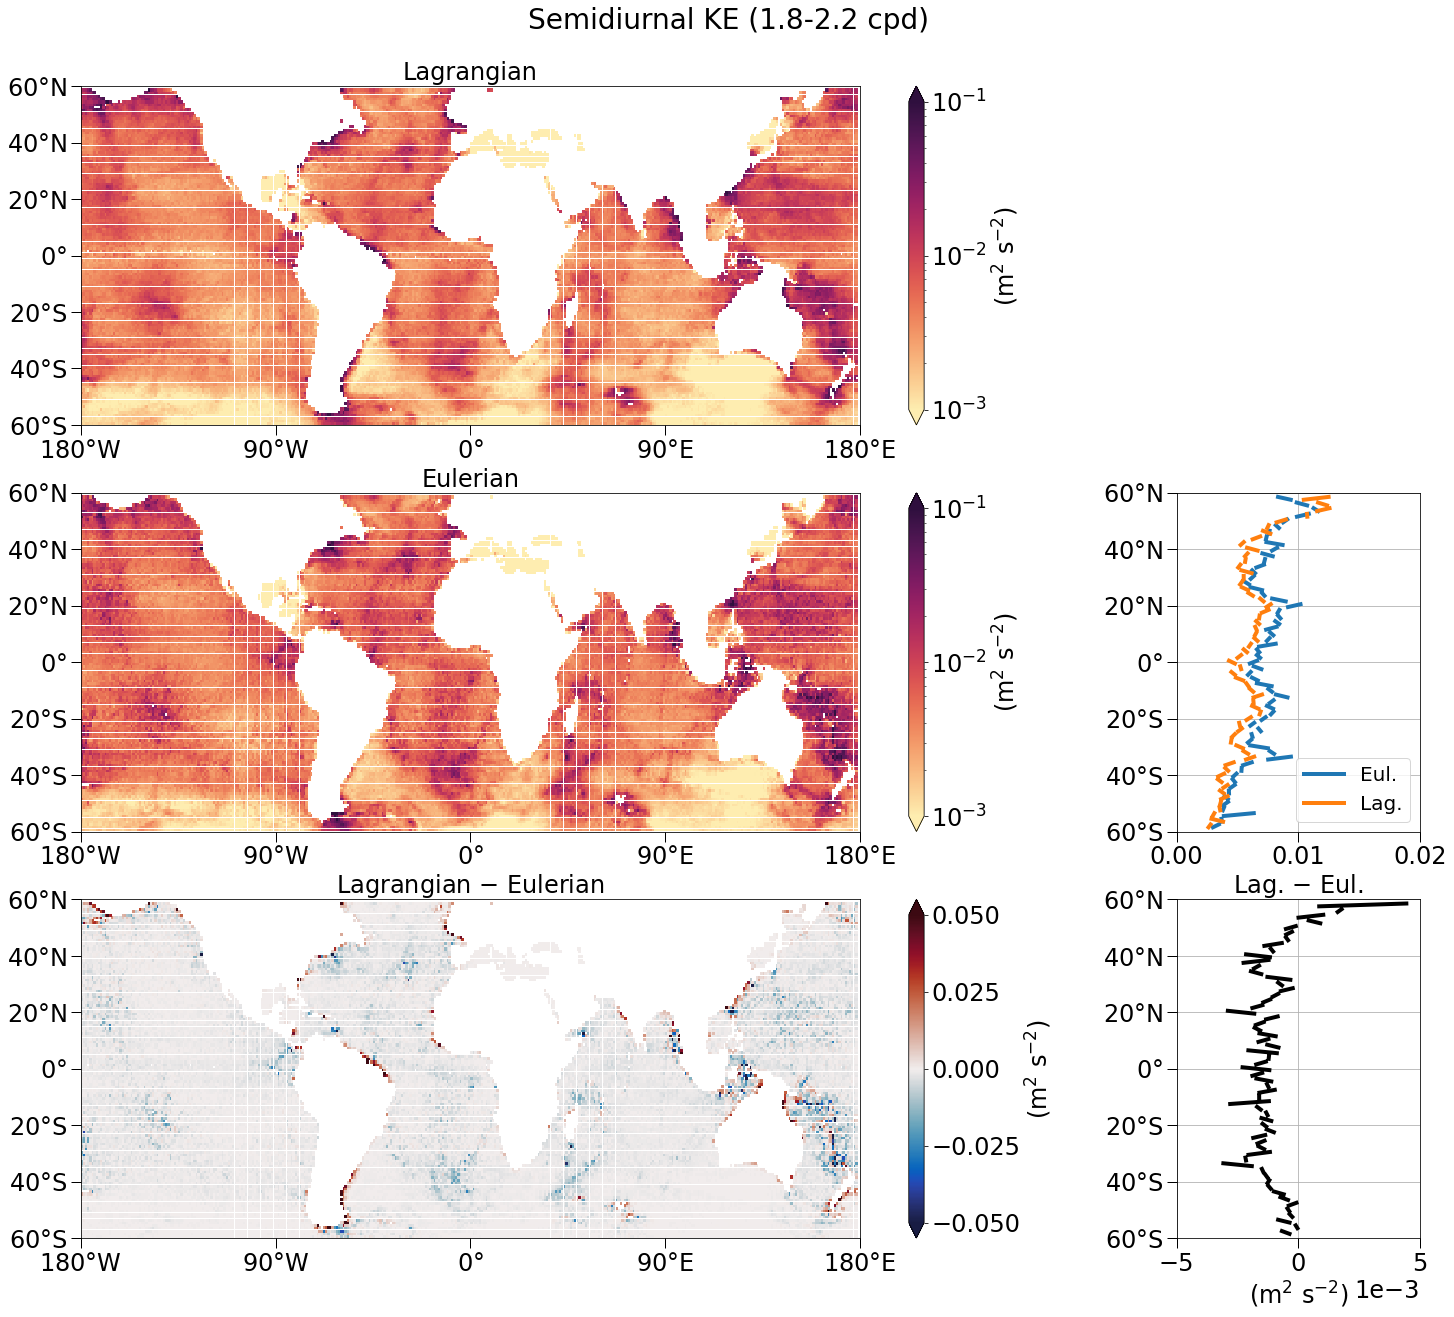

In [17]:
# semidiurnal 
upper_limit = 0.1
plt.rc('font', size=24) 

font_size = 24
band = 'semidiurnal_0dot2' # bandwidth 1.8-2.2 cpd
fig, ax = plt.subplots(figsize=(24,20))
fig.subplots_adjust(top=0.925)

fig.suptitle("Semidiurnal KE (1.8-2.2 cpd)",fontsize=font_size+4, y=0.98)
gs = gridspec.GridSpec(3, 2, width_ratios=[4,1]) 

ax = plt.subplot(gs[0])
cax=(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Lagrangian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

ax = plt.subplot(gs[2])
cax=(ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.matter, norm=colors.LogNorm(vmin=1e-3, vmax=1e-1), add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.set_title('Eulerian',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[3])
ds_E.E_Eulerian.sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:blue', label=labels[0], linewidth=4) # total energy
ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band).mean('lon_bins').plot(y='lat_bins',color='tab:orange', label=labels[1], linewidth=4) # total energy
ax.legend(prop={'size': font_size-4},frameon=True); ax.grid()
# x,y ticks
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_xlim([0,0.02])
ax.set_xticks([0,0.01,0.02])
ax.tick_params(direction='out', length=10, width=1)
# Label, size
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_title('',fontsize=font_size)


ax = plt.subplot(gs[4])
cax = (ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).plot(x='lon_bins', y='lat_bins', cmap=cm.balance, vmin=-0.05, vmax=0.05, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical', ticks=[-0.05, -0.025, 0, 0.025, 0.05])
cbar.ax.tick_params(labelsize=font_size)
ax.set_title('Lagrangian $-$ Eulerian',fontsize=font_size)
ax.set_xlim(-180., 180.)
ax.set_xticks([-180., -90., 0., 90., 180.])
ax.set_xticklabels(['$180\degree$W','$90\degree$W','$0\degree$','$90\degree$E','$180\degree$E'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
cbar.set_label('(m$^2$ s$^{-2}$)', fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('',fontsize=font_size)

labels = ['Eul.', 'Lag.']
ax = plt.subplot(gs[5])
(ds_E.E_Lagrangian.where(ds_E.E_Lagrangian<upper_limit).sel(frequency_band=band)-ds_E.E_Eulerian.sel(frequency_band=band)).mean('lon_bins').plot(y='lat_bins',linewidth=4,color='black')
ax.set_title('Lag. $-$ Eul.',fontsize=font_size)
ax.set_xlim(-0.005, 0.005)
ax.set_yticks([-0.005, -0.0025, 0, 0.0025, 0.005])
ax.set_yticklabels(['-0.005','','0','','0.005'])
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.tick_params(direction='out', length=10, width=1)
ax.grid()
ax.tick_params(labelsize=font_size)
ax.set_ylabel('',fontsize=font_size)
ax.set_xlabel('(m$^2$ s$^{-2}$)',fontsize=font_size)
plt.ticklabel_format(axis='x',style='sci', scilimits=(0,0))

In [11]:
# Save datasets
filename = 'sd_band_dl'+str(dl)+'.nc'
ds_E.to_netcdf('/home1/datawork/zcaspar/mit4320/'+filename)

In [7]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/